<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Market_demand_forecasting/arima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

In [3]:
# Load the dataset (adjust the file path in Colab as needed)
file_path = '/content/Ladders updated data.xlsx'
data = pd.ExcelFile(file_path)

# Load the 'Data' sheet
df = data.parse('Data')

# Display the first few rows to understand the structure
print(df.head())

  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  QTY(EA)  
0  Multy Purpose Ladder        1  
1           STEP LADDER        1  
2           STEP LADDER        1  
3           STEP LADDER        1  
4           STEP LADDER        1  


In [4]:
# Convert 'Billing Date' to datetime
df['Billing Date'] = pd.to_datetime(df['Billing Date'])

# Remove commas and convert 'Invoice Value' to numeric
df['Invoice Value'] = df['Invoice Value'].replace({',': ''}, regex=True).astype(float)


In [5]:
# Rename 'QTY(EA)' to 'Quantity'
df.rename(columns={'QTY(EA)': 'Quantity'}, inplace=True)

# Handle negative values (optional: filter out returns/cancellations)
df = df[(df['Quantity'] > 0) & (df['Invoice Value'] > 0)]

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Billing Date     0
Net Weight       0
Sales Region     0
Invoice Value    0
Material Code    0
Size             0
Quantity         0
dtype: int64


In [6]:
# Remove duplicates
df = df.drop_duplicates()

print("\nCleaned Dataset:")
print(df)


Cleaned Dataset:
     Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0      2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1      2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2      2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3      2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4      2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   
...           ...         ...          ...            ...                ...   
7647   2024-10-29   31.040000           R3       79022.08  FAML0304N000N1200   
7648   2024-10-29   40.785000           R3       91962.00  FAML0404N000N1600   
7649   2024-10-29   63.000000           R3       13274.60  FASL3000M000L0400   
7650   2024-10-29  105.000000           R3       27722.61  FASL3000M000L0500   
7651   2024-10-29  105.000000           R3       33187.83  FASL3000M000L0600   

                     

In [7]:
region_data = {
    'Sales Region': ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'PR', 'PR-EX', 'EX', 'DR'],
    'Region Name': ['North', 'Kandy', 'Kurunagela', 'Southern', 'Negombo', 'East', 'Colombo', 'Key accounts', 'Projects', 'Projects Export', 'Exports', 'Direct']
}
region_df = pd.DataFrame(region_data)
df = df.merge(region_df, on='Sales Region', how='left')

# Create 'Is_Export' feature
df['Is_Export'] = df['Sales Region'].apply(lambda x: 1 if x in ['EX', 'PR-EX'] else 0)


In [8]:
# Create 'Product Category' feature
df['Product Category'] = df['Material Code'] + ' - ' + df['Size']

# Create 'Price per Unit' feature
df['Price per Unit'] = df['Invoice Value'] / df['Quantity']

In [9]:
# Extract time-based features
df['Year'] = df['Billing Date'].dt.year
df['Month'] = df['Billing Date'].dt.month
df['Day'] = df['Billing Date'].dt.day
df['Day of Week'] = df['Billing Date'].dt.dayofweek

In [10]:
# Create 'Season' feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

print("\nDataset after Feature Engineering:")
print(df.head())


Dataset after Feature Engineering:
  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  Quantity Region Name  Is_Export  \
0  Multy Purpose Ladder         1     Exports          1   
1           STEP LADDER         1       Kandy          0   
2           STEP LADDER         1       Kandy          0   
3           STEP LADDER         1       Kandy          0   
4           STEP LADDER         1       Kandy          0   

                           Product Category  Price per Unit  Year  Month  Day  \
0  FAML0504N000N2000 - Multy Purpose Ladder           71.50

In [11]:
# Select features and target
X = df[['Net Weight', 'Invoice Value', 'Quantity', 'Year', 'Month', 'Day', 'Day of Week', 'Is_Export', 'Price per Unit']]
y = df['Quantity']

In [12]:
# Encode categorical features
categorical_features = ['Region Name', 'Product Category', 'Season']
X_categorical = df[categorical_features]

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X_categorical)
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

<ipython-input-13-5f30566ec908>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Billing Date', y='Quantity', data=df, estimator='sum', ci=None)


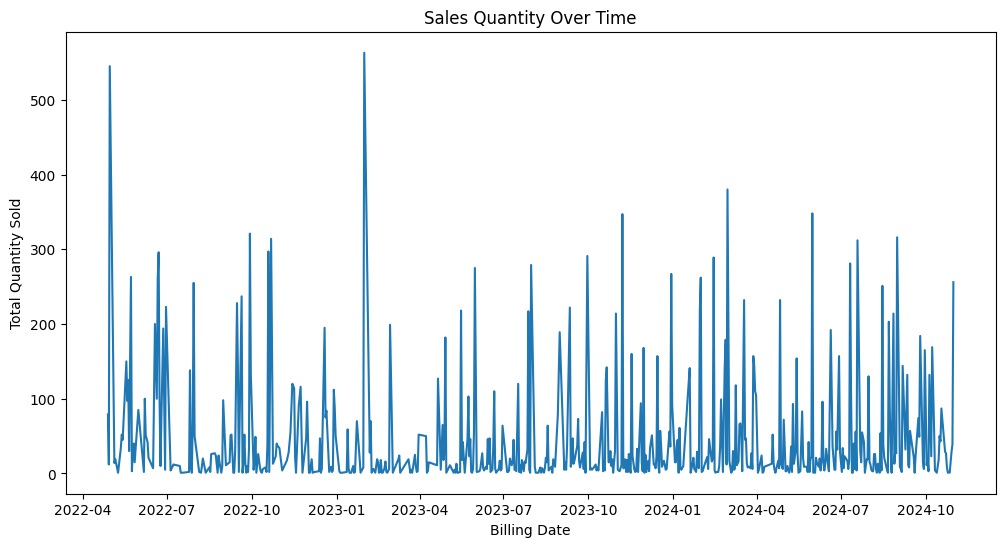

In [13]:
# Visualization 1: Sales Trends Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Billing Date', y='Quantity', data=df, estimator='sum', ci=None)
plt.title('Sales Quantity Over Time')
plt.xlabel('Billing Date')
plt.ylabel('Total Quantity Sold')
plt.show()


<ipython-input-14-283770a22eef>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Region Name', y='Quantity', data=df, estimator=sum, ci=None)


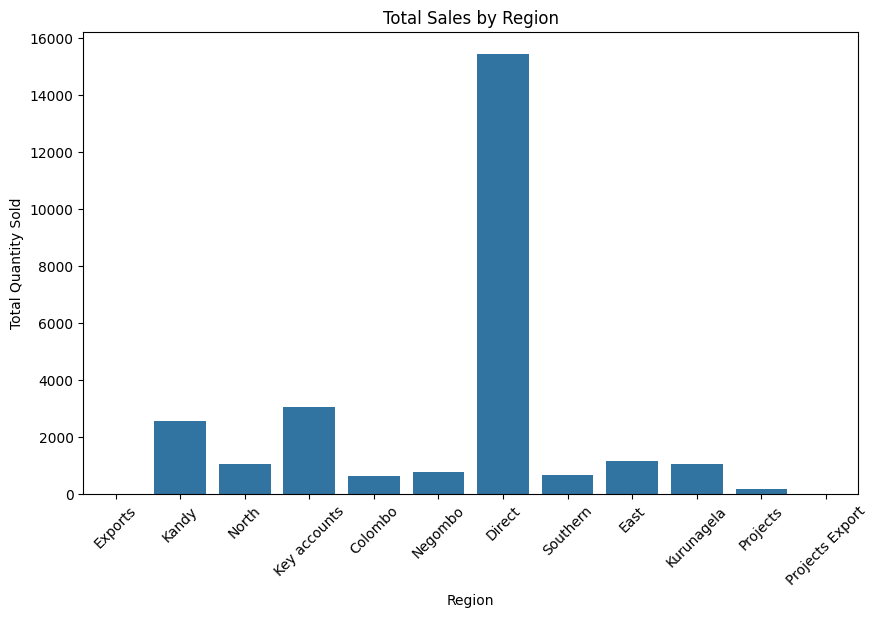

In [14]:
# Visualization 2: Sales by Region
plt.figure(figsize=(10, 6))
sns.barplot(x='Region Name', y='Quantity', data=df, estimator=sum, ci=None)
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-65d7a82e7926>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Product Category', y='Quantity', data=df, estimator=sum, ci=None)


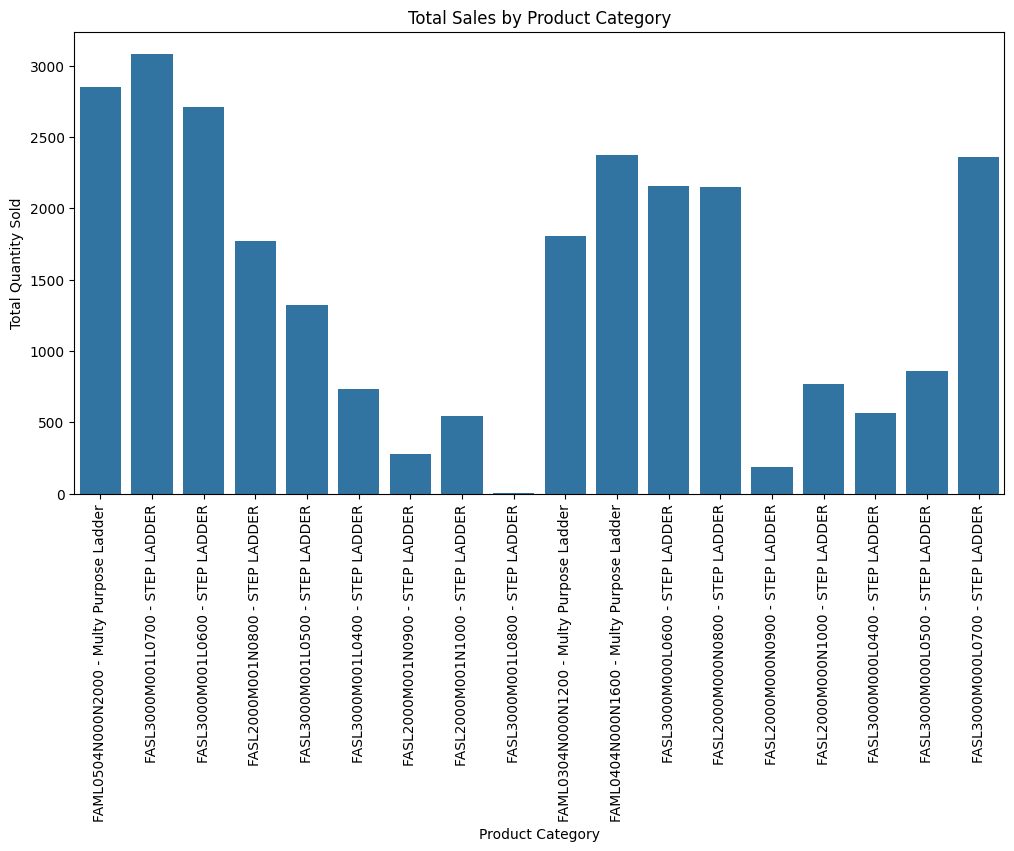

In [15]:
# Visualization 3: Sales by Product Category
plt.figure(figsize=(12, 6))
sns.barplot(x='Product Category', y='Quantity', data=df, estimator=sum, ci=None)
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)
plt.show()

<ipython-input-19-56984d304b56>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Quantity'].resample('M').sum()


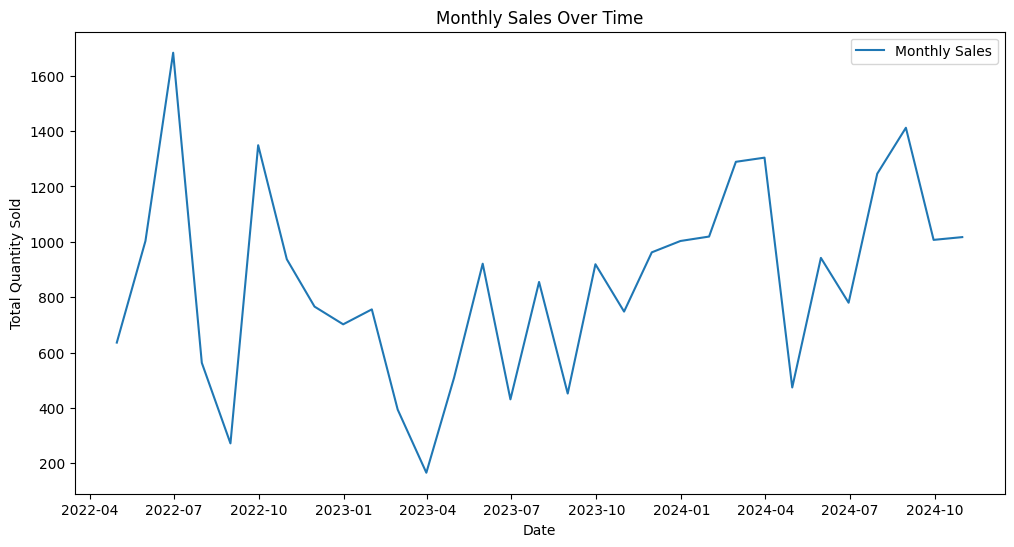

In [19]:

# Convert 'Billing Date' to datetime and set it as the index
df['Billing Date'] = pd.to_datetime(df['Billing Date'])
df.set_index('Billing Date', inplace=True)

# Aggregate sales data by month
monthly_sales = df['Quantity'].resample('M').sum()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.show()

In [22]:
# Split the data into training and testing sets
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

# Fit the ARIMA model
# Note: You may need to experiment with (p, d, q) values
model = ARIMA(train, order=(5, 1, 0))  # Example: ARIMA(5, 1, 0)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                   24
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -167.066
Date:                Wed, 05 Feb 2025   AIC                            346.132
Time:                        18:51:44   BIC                            352.944
Sample:                    04-30-2022   HQIC                           347.845
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6972      0.241     -2.889      0.004      -1.170      -0.224
ar.L2         -0.6342      0.321     -1.979      0.048      -1.262      -0.006
ar.L3         -0.1848      0.336     -0.550      0.5

RMSE: 375.04631344050574
MAE: 315.9391159081891


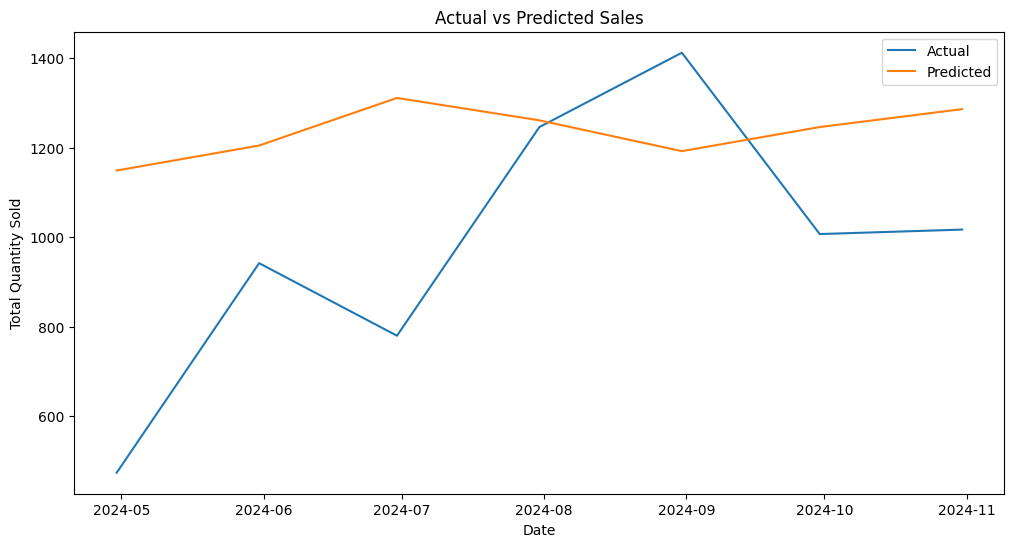

In [25]:
# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.show()

In [27]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.9 MB/s eta 0:00:00


In [29]:
# Use auto_arima to find the best ARIMA parameters
auto_model = auto_arima(
    train,
    seasonal=False,  # Set to True if you suspect seasonality
    trace=True,      # Print logs while searching
    error_action='ignore',  # Ignore invalid parameter combinations
    suppress_warnings=True,  # Suppress warnings
    stepwise=True    # Use a stepwise algorithm to find the best model
)

# Print the best model summary
print(auto_model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=364.200, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=396.238, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=365.802, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=382.223, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=362.403, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=378.239, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=360.806, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=362.767, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=365.828, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=357.432, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=355.022, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=354.245, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=355.386, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.814 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                        SARIMAX   Log Likelihood                -175.123
Date:                Wed, 05 Feb 2025   AIC                            354.245
Time:                        18:55:45   BIC                            356.601
Sample:                    04-30-2022   HQIC                           354.870
                         - 03-31-2024                      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [30]:
# Fit the best ARIMA model found by auto_arima
best_model = auto_model

# Make predictions on the test set
predictions = best_model.predict(n_periods=len(test))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 326.414853366105
MAE: 273.5892857142856


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


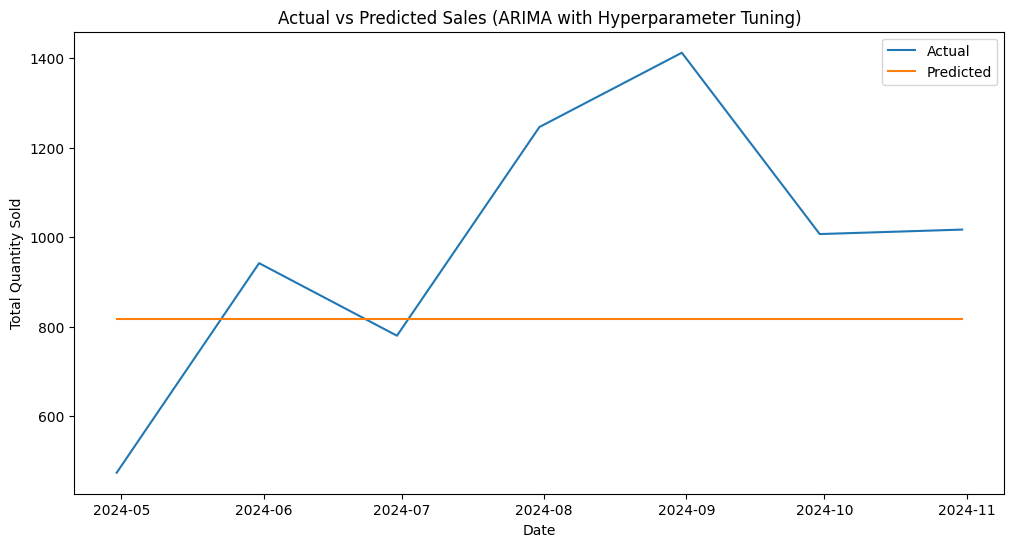

In [31]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Sales (ARIMA with Hyperparameter Tuning)')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.show()